Tukaj sem uporabil 2 dataseta celic trebušne slinavke. Za markerje sem uporabil bazo Panglao Gene Markers.

Dataset Baron (2016) sem uporabil za treniranje mreže, ker ima več celic in razredov.

In [1]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Orange.data import Table
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
%matplotlib inline

#tensorboard = TensorBoard(log_dir='logs/MarkersOnly/{}'.format(time()))

SPECIES = 'Human'
DATASET_1_PATH = '/home/mlongar/Data/SingleCellGeneExpression/baron_2016h.h5ad'
DATASET_2_PATH = '/home/mlongar/Data/SingleCellGeneExpression/xin_2016.h5ad'
MARKER_PATH = '/home/mlongar/Data/SingleCellGeneExpression/panglao_gene_markers.tab.gz'

In [2]:
EPOCHS = 100
BOTTLENECK = 25

# Load the data

In [3]:
dataset = read_h5ad(DATASET_1_PATH)
data = dataset.to_df()
labels = dataset.obs["labels"]

new_dataset = read_h5ad(DATASET_2_PATH)
new_data = new_dataset.to_df()
new_labels = new_dataset.obs["labels"]

markers = Table(MARKER_PATH)

In [4]:
print(data.shape)
print(new_data.shape)

(8569, 20125)
(1492, 39851)


Baron ima 8569 celic in 20125 genov.

Xin ima 1492 celic in 39851 genov.

# Drop rows

Iz podatkov sem odstranil vse neklasificirane celice.

In [5]:
to_drop = []
for i, c_type in enumerate(labels.tolist()):
    if c_type == 'Other':
        to_drop.append(i)

In [6]:
data = data.drop(data.index[to_drop], axis=0)
labels = labels.drop(labels.index[to_drop], axis=0)

In [7]:
print(labels.shape)
print(data.shape)

(8451,)
(8451, 20125)


# Load marker genes

#### Load only the specified marker genes

In [8]:
markers_db = []
for meta in markers.metas:
    if meta[0] == SPECIES:
        markers_db.append(meta)

#### Get the used marker genes

In [9]:
def get_used_markers(data, markers=markers_db):
    used_markers = []
    for i, gene_name in enumerate(data.columns):
        for marker in markers:
            if gene_name == marker[1]:
                used_markers.append((gene_name, marker))
    return used_markers

used_markers = get_used_markers(data)
new_used_markers = get_used_markers(new_data)

In [10]:
markers_to_keep = []
for marker in used_markers:
    marker_found = False
    for new_marker in new_used_markers:
        if marker[0] == new_marker[0] and marker[1][2] == new_marker[1][2]:
            markers_to_keep.append(marker)

In [11]:
print(len(used_markers), len(new_used_markers))
print(len(markers_to_keep))

7618 7610
7545


Baron ima 7618 markerjev, Xin pa 7610.

Uporabil sem samo tiste, ki so skupni obema. Takih je 7545.

### Get the cell types

In [12]:
from collections import OrderedDict

def get_cell_types(used_markers):
    cell_types = OrderedDict()
    for marker in used_markers:
        c_type = marker[1][2]
        gene_name = marker[0]
        if c_type in cell_types:
            if gene_name not in cell_types[c_type]:
                cell_types[c_type].append(gene_name)
        else:
            cell_types[c_type] = [gene_name]
    return cell_types

cell_types = get_cell_types(markers_to_keep)

### Make sure every class is in the marker layer

In [13]:
def get_used_genes(cell_types):
    used_genes = []
    for c_type in cell_types:
        genes = cell_types[c_type]
        for gene in genes:
            if gene not in used_genes:
                used_genes.append(gene)
    return used_genes

used_genes = get_used_genes(cell_types)

Ker so celice v datasetih malo drugace poimenovane kot pa v bazi markerjev, sem tukaj naredil en dictionary drugacnih imen in preveril če katera manjkajo.

In [16]:
marker_names = {'PaSC' : 'Pancreatic stellate cells',
                'PP cells' : 'Gamma (PP) cells',
                'Endothelial cell' : 'Endothelial cells'}

used_types = []
for c_type in cell_types:
    used_types.append(c_type)

for c_type in labels.unique():
    if c_type not in used_types and c_type not in list(marker_names.keys()):
        print(c_type)
for c_type in new_labels.unique():
    if c_type not in used_types and c_type not in list(marker_names.keys()):
        print(c_type)

# Gene selection

**Uporabil sem samo tiste gene, ki so skupni obema datasetoma in ki so v bazi markerjev (torej so povezani z delnopovezanim slojem v avtoenkoderju).**

Takih genov je v tem primeru 4173.

In [15]:
gene_mask = np.zeros(len(data.columns), dtype=bool)
new_gene_mask = np.zeros(len(new_data.columns), dtype=bool)

In [17]:
to_drop = []
for i, keep in enumerate(gene_mask):
    gene_name = data.columns[i]
    if keep == False and gene_name not in used_genes:
        to_drop.append(data.columns[i])

new_to_drop = []
for i, keep in enumerate(new_gene_mask):
    gene_name = new_data.columns[i]
    if keep == False and gene_name not in used_genes:
        new_to_drop.append(new_data.columns[i])

In [18]:
data.shape[1] - len(to_drop)

4173

In [19]:
new_data.shape[1] - len(new_to_drop)

4173

## Drop unused genes

In [20]:
data = data.drop(to_drop, axis=1)
new_data = new_data.drop(new_to_drop, axis=1)

## Sort columns by name

In [21]:
data = data.reindex(sorted(data.columns), axis=1)
new_data = new_data.reindex(sorted(new_data.columns), axis=1)

In [22]:
new_data.columns.values == data.columns.values

array([ True,  True,  True, ...,  True,  True,  True])

# Data transformation

#### Shuffle the data

In [23]:
idx = np.random.permutation(data.index)
data_x = data.reindex(idx)
data_y = labels.reindex(idx)

#### Log10 transformation

In [24]:
data_x = np.log10(data_x + 1)
new_data_x = np.log10(new_data + 1)

#### Split the data

In [25]:
seventy = int(data_x.shape[0] * 0.7)
fifteen = int(data_x.shape[0] * 0.15)

In [26]:
train_x = data_x[:seventy]
train_y = data_y[:seventy]

test_x = data_x[seventy:seventy+fifteen]
test_y = data_y[seventy:seventy+fifteen]

validation_x = data_x[seventy+fifteen:]
validation_y = data_y[seventy+fifteen:]

In [27]:
data.shape

(8451, 4173)

In [28]:
new_data.shape

(1492, 4173)

# Build the model

Tukaj sem definiral delnopovezan sloj markerjev.

Sloj ima vozlišče za vsak celčni tip, katerega geni so prisotni v obeh bazah. V tem primeru je v sloju markerjev 179 vozlišč, ki predstavlja 179 celičnih tipov. Vsako vozlišče (torej celični tip) je na vhodu povezano samo z geni, ki so njegovi markerji.

Do delnopovezanega sloja sem prišel tako, da sem vzel polnopovezan sloj in mu dodal masko (matrika enk in ničel), ki jo pomnožim z matriko uteži.

Mrežo sem treniral 100 epoh.

### Arhitektura
|Sloj|Vozlišča|
|----|--------|
|Vhod|4173 (genov)|
|Markerji|179 (celičnih tipov)|
|Polnopovezan sloj|100|
|**Bottleneck**|**25**|
|Polnopovezan sloj|100|
|*Dropout*|*10%*|
|Izhod|4173 (genov)|

In [17]:
from keras import backend as K
from keras.layers import Layer
from keras import activations, initializers, regularizers, constraints
from keras.engine.base_layer import InputSpec
from tensorflow import convert_to_tensor
import tensorflow as tf

class Markers(Layer):

    def __init__(self, units, weight_mask,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Markers, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
        
        weight_mask = convert_to_tensor(np.transpose(weight_mask), dtype=tf.float32)
        self.weight_mask = weight_mask

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        conns = tf.multiply(self.kernel, self.weight_mask)
        output = K.dot(inputs, conns)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Markers, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Using TensorFlow backend.


In [30]:
def get_weight_mask(types, n_dim, num_types, data=data):
    mask = np.zeros(shape=(num_types, n_dim))
    for i, cell_type in enumerate(types):
        for gene in types[cell_type]:
            gene_index = data.columns.get_loc(gene)
            mask[i][gene_index] = 1.0
    return mask

In [31]:
from keras.layers import Input, Dense, Add, Dropout
from keras.models import Model

def build_model(input_dim, marker_dim, bottleneck_dim, types=cell_types):
    weight_mask = get_weight_mask(types=types, num_types=num_types, n_dim=input_dim)
    
    input_layer = Input(shape=(input_dim,))
    marker_layer = Markers(marker_dim, weight_mask=weight_mask, activation='relu')(input_layer)
    
    dense_in_1 = Dense(100, activation='relu')(marker_layer)
    bottleneck_layer = Dense(bottleneck_dim, activation='relu', name='Bottleneck')(dense_in_1)
    dense_out_1 = Dense(100, activation='relu')(bottleneck_layer)
    dropout = Dropout(0.1)(dense_out_1)
    
    output_layer = Dense(input_dim, activation='relu', name='Output')(dropout)
    
    model = Model(input_layer, output_layer)
    model.compile(loss='mse', optimizer='adam')
    
    marker_model = Model(input_layer, marker_layer)
    marker_model.compile(loss='mse', optimizer='adam')
    
    encoder_model = Model(input_layer, bottleneck_layer)
    encoder_model.compile(loss='mse', optimizer='adam')
    
    return model, marker_model, encoder_model

def train_model(model, data, validation_data, test_data, epochs=30, batch_size=256, verbose=1, callbacks=[]):
    history = model.fit(data, data,
               epochs=epochs, batch_size=batch_size,
               validation_data=(validation_data, validation_data),
               callbacks=callbacks,
               verbose=verbose)
    loss = model.evaluate(test_data, test_data)
    return (history, loss)

def draw_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss', c='orange')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

#### Create the model

In [ ]:
n_genes = train_x.shape[1]
num_types = len(cell_types)

model, marker_model, encoder_model = build_model(input_dim=n_genes,
                                                 marker_dim=num_types,
                                                 bottleneck_dim=BOTTLENECK,
                                                 types=cell_types)

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4173)              0         
_________________________________________________________________
markers_1 (Markers)          (None, 179)               747146    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               18000     
_________________________________________________________________
Bottleneck (Dense)           (None, 25)                2525      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
Output (Dense)               (None, 4173)              421473    
Total para

# Train the model

Instructions for updating:
Use tf.cast instead.
1267/1267 [==============================] - 0s 322us/step


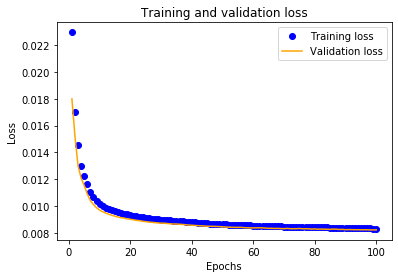

In [34]:
history, loss = train_model(model, train_x, validation_x, test_x, epochs=EPOCHS, verbose=0, callbacks=[])#tensorboard
draw_history(history)

In [35]:
print("Test loss: ", loss)

Test loss:  0.008463835438541427


#### Save the model

In [36]:
model.save('markersonly_comparison.h5')
marker_model.save('markersonly_comparison_marker.h5')
encoder_model.save('markersonly_comparison_encoder.h5')

model.save_weights('markersonly_comparison_weights.h5')
marker_model.save_weights('markersonly_comparison_marker_weights.h5')
encoder_model.save_weights('markersonly_comparison_encoder_weights.h5')

# Data analysis

In [37]:
def get_results(cell_types, cell_activations, graph_labels):
    types_list = list(cell_types.items())
    top3s = []
    top3s_act = []
    for cell in cell_activations:
        top3 = cell.argsort()[-3:][::-1]
        top3types = [types_list[i][0] for i in top3]
        top3s.append(top3types)
        
        act = np.zeros((len(cell_activations[0]),))
        for i in top3:
            act[i] = cell[i]
        top3s_act.append(act)

    n = 0
    correct = 0
    for i in range(len(top3s)):
        prediction = top3s[i][0]
        label = graph_labels.iloc[i]

        if str(prediction) == 'nan' or str(label) == 'nan':
            continue

        if prediction == label:
            correct += 1

        elif label in marker_names.keys():
            if marker_names[label] == prediction:
                correct += 1
        n += 1

    print("Correct predictions: {c} out of {n} ({p}%)".format(c=correct, n=n, p=round(100 * (correct/n), 2)))
    print("Dropped {d} cells".format(d=len(cell_activations) - n))
    return top3s_act

In [38]:
cell_activations = marker_model.predict(test_x)
bottleneck_activations = encoder_model.predict(test_x)
graph_labels = test_y

**Mreža pravilno klasificira 82% testnih podatkov (iz baze na kateri se je učila)**

In [39]:
top3 = get_results(cell_types, cell_activations, graph_labels)

Correct predictions: 1044 out of 1267 (82.4%)
Dropped 0 cells


Spodnji graf prikazuje aktivacije tipov celic. Razvidno je, da izstopa samo en celični tip, ostali tipi pa izrecno manj.

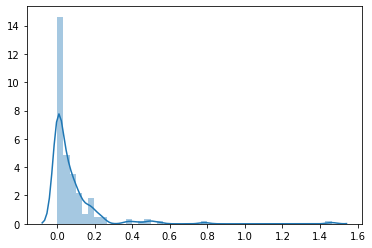

In [77]:
import seaborn as sns
sns.distplot(cell_activations[0])

### New data

In [40]:
new_cell_activations = marker_model.predict(new_data_x)
new_bottleneck_activations = encoder_model.predict(new_data_x)
new_graph_labels = new_labels

**Mreža pravilno klasificira 86% čisto novih podatkov iz druge baze**

In [41]:
new_top3 = get_results(cell_types, new_cell_activations, new_graph_labels)

Correct predictions: 1288 out of 1492 (86.33%)
Dropped 0 cells


## Graphs

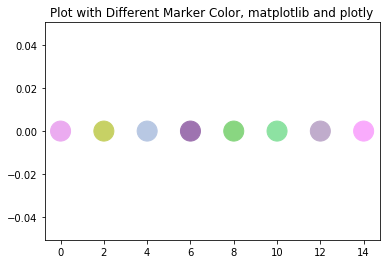

In [42]:
import random

def get_random_color(pastel_factor = 0.5):
    pastel_factor = random.uniform(0, 1.0)
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

colours = {}
for label in graph_labels.unique():
    colour = (get_random_color())
    colours.update({label:colour})
    
fig = plt.figure()
ax = fig.add_subplot(111)

x = list(range(0, len(colours.values()) * 2, 2))
y = [0]*len(x)
c = list(colours.values())

ax.scatter(x,y,s=400,c=c)
ax.set_title('Plot with Different Marker Color, matplotlib and plotly')

plt.show()

In [43]:
import pickle

pickle_in = open("Data/Marker_Colours.pickle","rb")
colours = pickle.load(pickle_in)

In [44]:
pickle_out = open("Data/Marker_Colours.pickle","wb")
pickle.dump(colours, pickle_out)
pickle_out.close()

In [45]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import OrderedDict
import operator

tnse = TSNE()
pca = PCA()
    
def draw_graph(x, y, model, colours, graph_name=''):
    tsne_out = model.fit_transform(x)
    
    plt.clf()
    plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

    for i, entry in enumerate(tsne_out):
        plt.scatter(entry[0], entry[1], color=colours[y.iloc[i]], label=y.iloc[i])
    
    handles, plt_labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(plt_labels, handles))
    by_label = OrderedDict(sorted(by_label.items()))

    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0., 1, 0, .1))

    plt.title(graph_name)
    plt.axis('off')
    plt.show()

<Figure size 432x288 with 0 Axes>

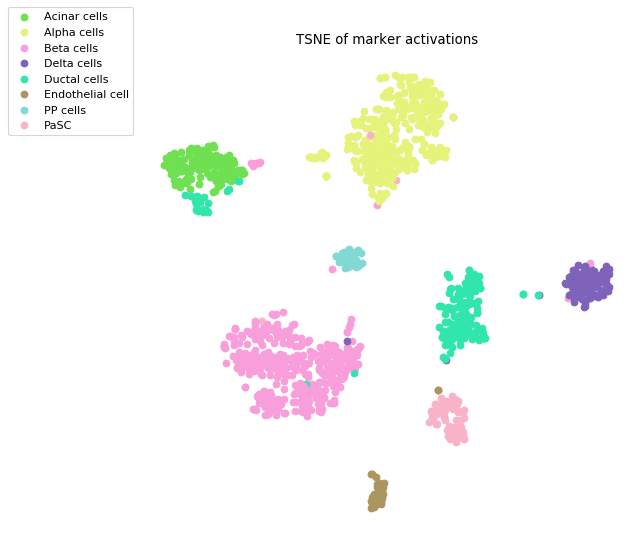

In [46]:
draw_graph(cell_activations, graph_labels, tnse, colours, graph_name='TSNE of marker activations')

# New Data

<Figure size 432x288 with 0 Axes>

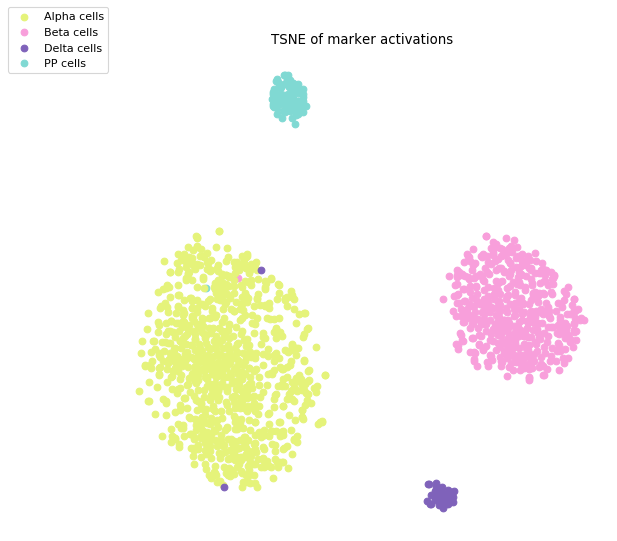

In [47]:
draw_graph(new_cell_activations, new_graph_labels, tnse, colours, graph_name='TSNE of marker activations')

# Combined data

In [49]:
def draw_comparison(x, y, new_alpha = 1.0, preloaded_tsne=None, title=''):
    if preloaded_tsne is None:
        tsne_out = tnse.fit_transform(x)
    else:
        tsne_out = preloaded_tsne

    plt.clf()
    plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

    for i, entry in enumerate(tsne_out):
        colour = colours[y.iloc[i]]
        alpha = 1.0
        marker = '.'
        if(i <= test_x.shape[0]):
            alpha = new_alpha
            marker = 'x'
        plt.scatter(entry[0], entry[1], color=colour, label=y.iloc[i], alpha=alpha, marker=marker)

    handles, plt_labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(plt_labels, handles))
    by_label = OrderedDict(sorted(by_label.items()))

    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0., 1, 0, .1))

    plt.title(title)
    plt.axis('off')
    plt.show()
    
    #return tsne_out

**Na spodnjem grafu lahko opaziš, da se batch effect še vedno opazi, tudi na aktivacijah markerjev**

<Figure size 432x288 with 0 Axes>

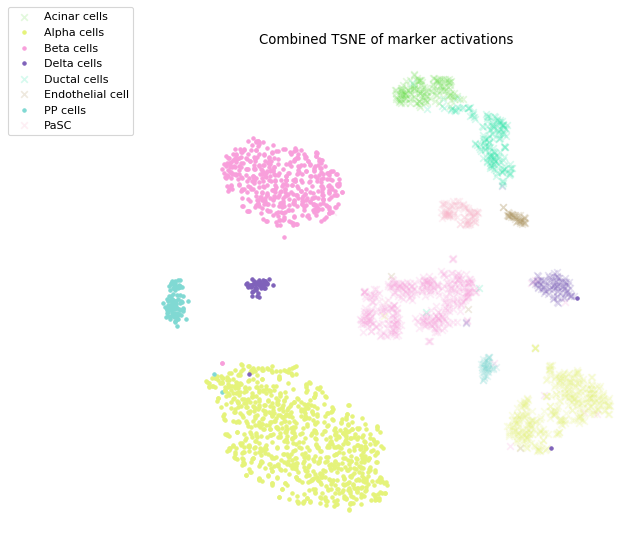

In [50]:
x = test_x.append(new_data_x)
y = test_y.append(new_labels)
compare_cell_activations = encoder_model.predict(x)
tsne_out = draw_comparison(compare_cell_activations, y, new_alpha=0.2, title='Combined TSNE of marker activations')

<Figure size 432x288 with 0 Axes>

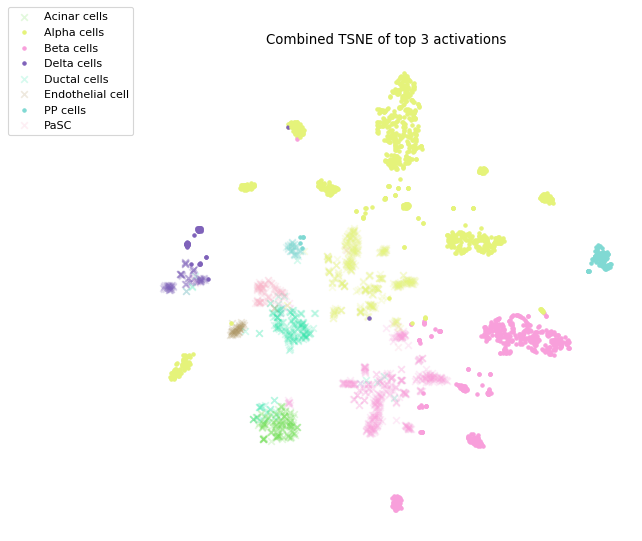

In [51]:
draw_comparison(np.vstack((top3, new_top3)), y, new_alpha=0.2, title='Combined TSNE of top 3 activations')

# Reconstruction

**Tukaj sem vzel nove podatke in jih vrgel v avtoenkoder.**

**Nato sem vzel izhodne podatke avtoenkoderja ter vzel njihove aktivacije sloja markerjev.**

**Tako sem dobil nove rezultate, ki so bili konsistentno boljši. V tem primeru za 11%.**

Moja hipoteza je, da se tako delno znebimo batch effecta in zato dobimo boljše rezultate.

In [56]:
reconstruction = model.predict(new_data_x)
reconstruction = pd.DataFrame(reconstruction, columns=new_data_x.columns)
reconstructed_cell_activations = marker_model.predict(reconstruction)

<Figure size 432x288 with 0 Axes>

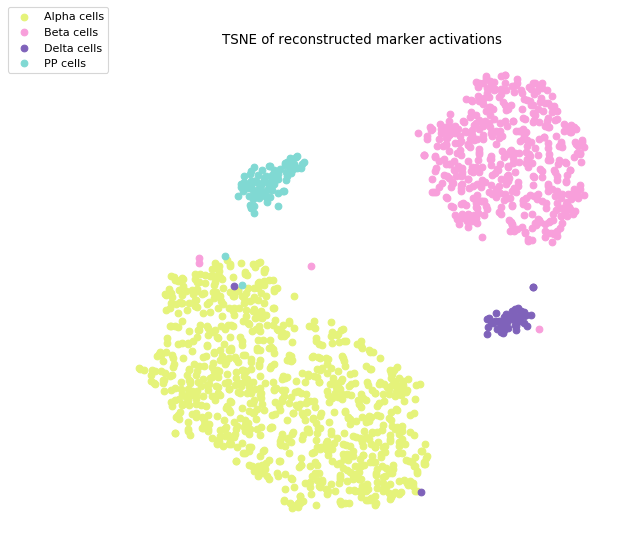

In [53]:
draw_graph(reconstructed_cell_activations, new_graph_labels, tnse, colours,
           graph_name='TSNE of reconstructed marker activations')

In [57]:
_ = get_results(cell_types, reconstructed_cell_activations, new_graph_labels)

Correct predictions: 1451 out of 1492 (97.25%)
Dropped 0 cells


Tudi pri teh podatkih batch effect še vedno ostane.

<Figure size 432x288 with 0 Axes>

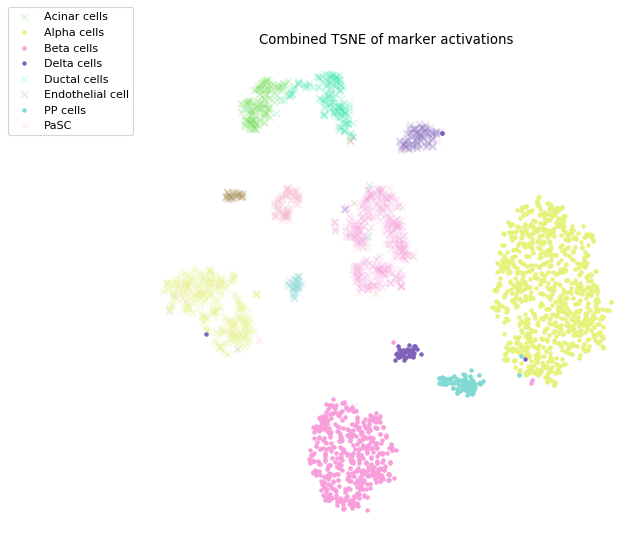

In [55]:
x = test_x.append(reconstruction)
y = test_y.append(new_labels)
compare_cell_activations = encoder_model.predict(x)
tsne_out = draw_comparison(compare_cell_activations, y, new_alpha=0.2, title='Combined TSNE of marker activations')

# Save the data

In [48]:
in_data = pd.DataFrame(new_data_x)
out_data = pd.DataFrame(data=model.predict(new_data_x))
in_data.to_pickle('Data/in_data_markersonly.pickle')
out_data.to_pickle('Data/out_data_markersonly.pickle')

# HTML

In [19]:
%%html
<style>
table {float:left}
</style>